In [1]:
import pandas as pd
from ydata_profiling import ProfileReport

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import MultinomialNB

In [2]:
fake_news = pd.read_csv('Data/Fake.csv')
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [3]:
real_news = pd.read_csv('Data/True.csv')
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


# EDA

## Fake News

In [4]:
print("Shape of the Fake News DataFrame:")
print("---------------------------------")
print(f'Shape: {fake_news.shape}')

Shape of the Fake News DataFrame:
---------------------------------
Shape: (23481, 4)


In [5]:
print("Breakdown of NaN entries in each column:")
print("----------------------------------------")
print(fake_news.isna().sum())

Breakdown of NaN entries in each column:
----------------------------------------
title      0
text       0
subject    0
date       0
dtype: int64


In [6]:
print("Breakdown of different entries in subject column:")
print("-------------------------------------------------")
print(fake_news['subject'].value_counts())

Breakdown of different entries in subject column:
-------------------------------------------------
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64


In [7]:
print("General information about the Fake News DataFrame:")
print("--------------------------------------------------")
print(fake_news.info())

General information about the Fake News DataFrame:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None


In [8]:
fake_news_profiling = ProfileReport(fake_news, title = "Fake News Profiling Report")
fake_news_profiling.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

The report shows that there are 3 duplicate rows in the Fake News DataFrame. However, what is interesting is that there are titles that are reused. Additionally, the contents of articles have been reused as well. 

It makes sense that there may be duplicate titles as there are only so many words that can be used to describe a situation and grab an audience's attention. I can only think of two different reasons why there might be duplicate text. The first is that the website is using A/B testing to determine the best title. The second reason is that the text was blatantly ripped from another article. 

Article on astroturfing:

https://www.cisa.gov/sites/default/files/publications/tactics-of-disinformation_508.pdf

In [9]:
# get the duplicate rows in the DataFrame
duplicates = fake_news[fake_news.duplicated(keep = False)]

In [10]:
print("Shape of the DataFrame holding duplicates:")
print("------------------------------------------")
print(f'Shape: {duplicates.shape}')

Shape of the DataFrame holding duplicates:
------------------------------------------
Shape: (6, 4)


In [11]:
# show the duplicated rows
duplicates.head(6)

,title,text,subject,date
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


In [12]:
title_duplicates = fake_news[fake_news.duplicated(subset = 'title', keep = False)]
title_duplicates.head()

,title,text,subject,date
1488,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 12, 2017"
1535,McConnell Says He’ll Obstruct ANY Effort To H...,Siding with Trump s Attorney General Jeff Sess...,News,"May 10, 2017"
9087,BARBRA STREISAND Gives Up On Dream Of Impeachi...,Barbra Streisand was an Obama sycophant and on...,politics,"Dec 31, 2017"
9088,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,Everyone suspected the sketchy Steele Dossier ...,politics,"Dec 31, 2017"
9089,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...,It s been said that good fences make good neig...,politics,"Dec 30, 2017"


In [13]:
print("Total repeat titles:")
print("--------------------")
print(f'{title_duplicates.shape[0] / 2}')

Total repeat titles:
--------------------
5337.0


In [14]:
text_duplicates = fake_news[fake_news.duplicated(subset = 'text', keep = False)]
text_duplicates.head()

,title,text,subject,date
9087,BARBRA STREISAND Gives Up On Dream Of Impeachi...,Barbra Streisand was an Obama sycophant and on...,politics,"Dec 31, 2017"
9088,WATCH: SENATOR LINDSEY GRAHAM DROPS BOMBSHELL…...,Everyone suspected the sketchy Steele Dossier ...,politics,"Dec 31, 2017"
9089,“CONSERVATIVE GAY GUY” BLASTS Pence’s Aspen Ne...,It s been said that good fences make good neig...,politics,"Dec 30, 2017"
9091,BILL NYE The FAKE Science Guy THREATENS Conser...,"Friday on MSNBC, climate activist Bill Nye war...",politics,"Dec 30, 2017"
9093,EMBARRASSING: Anti-Trump “THE HILL” Gets SLAMM...,"#JokeNewsAfter record, cold temperatures were ...",politics,"Dec 30, 2017"


In [15]:
print("Total repeat texts:")
print("------------------")
print(f'{text_duplicates.shape[0] / 2}')

Total repeat texts:
------------------
5477.0


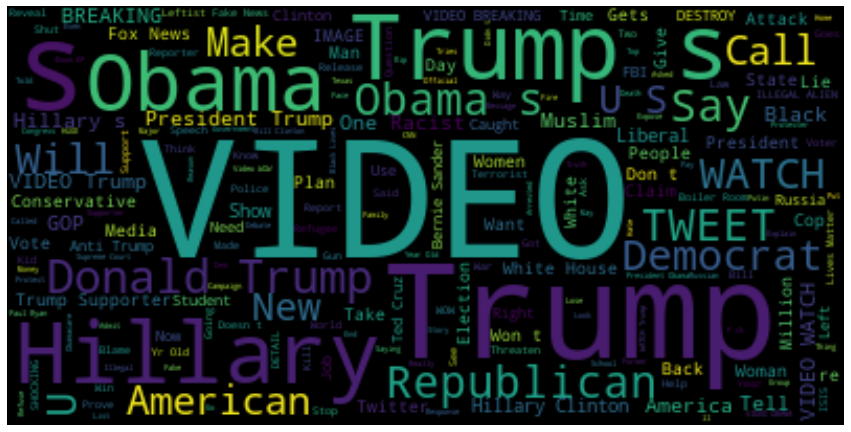

In [16]:
title_cloud = " ".join(i for i in fake_news['title'])
stopwords1 = set(STOPWORDS)
fake_news_title_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(title_cloud)
plt.figure(figsize = (15, 10))
plt.imshow(fake_news_title_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

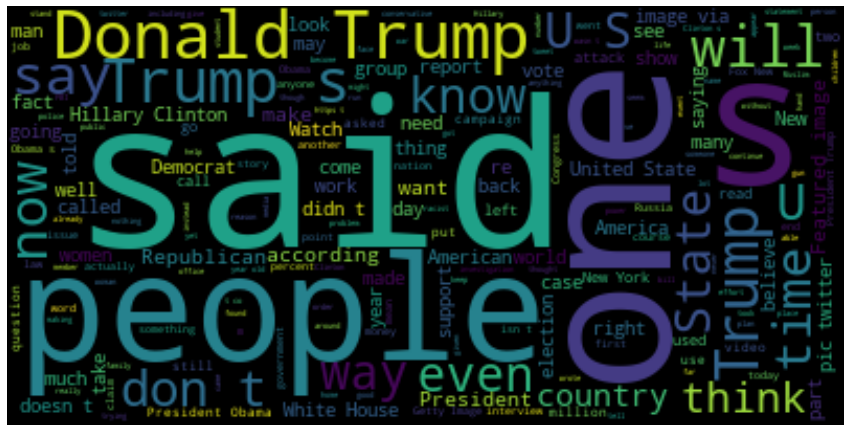

In [17]:
text_cloud = " ".join(i for i in fake_news['text'])
stopwords1 = set(STOPWORDS)
fake_news_text_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(text_cloud)
plt.figure(figsize = (15, 10))
plt.imshow(fake_news_text_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Real News

In [18]:
print("Shape of the Fake News DataFrame:")
print("---------------------------------")
print(f'Shape: {real_news.shape}')

Shape of the Fake News DataFrame:
---------------------------------
Shape: (21417, 4)


In [19]:
print("Breakdown of NaN entries in each column:")
print("----------------------------------------")
print(real_news.isna().sum())

Breakdown of NaN entries in each column:
----------------------------------------
title      0
text       0
subject    0
date       0
dtype: int64


In [20]:
print("Breakdown of different entries in subject column:")
print("-------------------------------------------------")
print(real_news['subject'].value_counts())

Breakdown of different entries in subject column:
-------------------------------------------------
politicsNews    11272
worldnews       10145
Name: subject, dtype: int64


In [21]:
print("General information about the Fake News DataFrame:")
print("--------------------------------------------------")
print(real_news.info())

General information about the Fake News DataFrame:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [22]:
real_news_profiling = ProfileReport(real_news, title = "Real News Profiling Report")
real_news_profiling.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [23]:
duplicated_real_news = real_news[real_news.duplicated(keep = False)]
duplicated_real_news.shape

(399, 4)

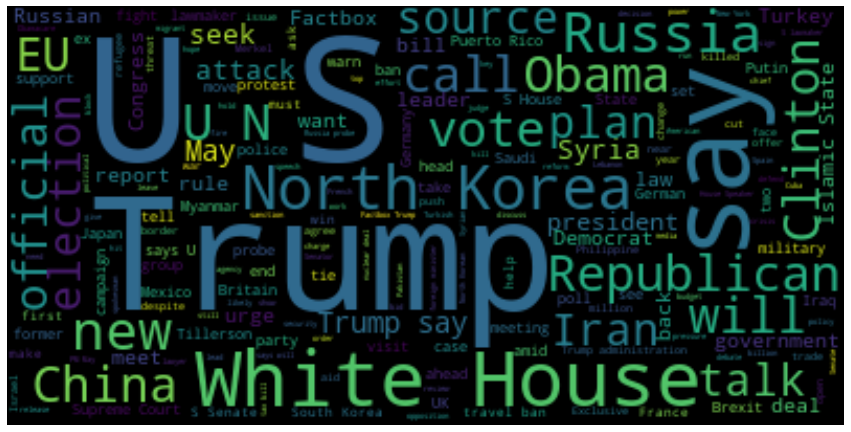

In [24]:
title_cloud2 = " ".join(i for i in real_news['title'])
stopwords1 = set(STOPWORDS)
real_news_title_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(title_cloud2)
plt.figure(figsize = (15, 10))
plt.imshow(real_news_title_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

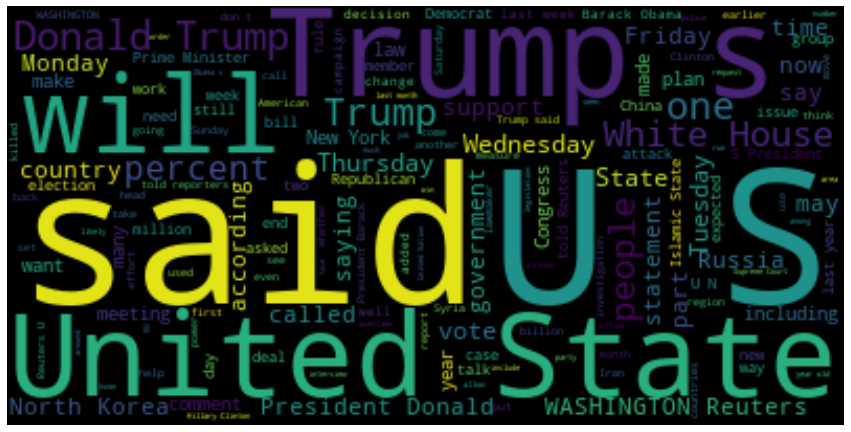

In [25]:
text_cloud2 = " ".join(i for i in real_news['text'])
stopwords1 = set(STOPWORDS)
real_news_text_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(text_cloud2)
plt.figure(figsize = (15, 10))
plt.imshow(real_news_text_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Preprocessing Data

## Merging DataFrames

In [26]:
fake_news['label'] = 1
fake_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [27]:
real_news['label'] = 0
real_news.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [28]:
news = [fake_news, real_news]
total_news = pd.concat(news, ignore_index = True)

In [29]:
# proper shape is 44898 before removing duplicates
total_news.shape

(44898, 5)

In [30]:
total_news.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


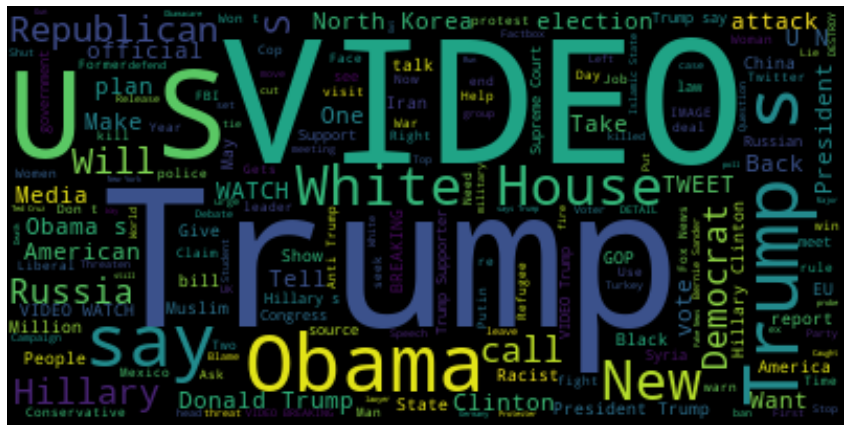

In [31]:
title_cloud3 = " ".join(i for i in total_news['title'])
stopwords1 = set(STOPWORDS)
total_news_title_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(title_cloud3)
plt.figure(figsize = (15, 10))
plt.imshow(total_news_title_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

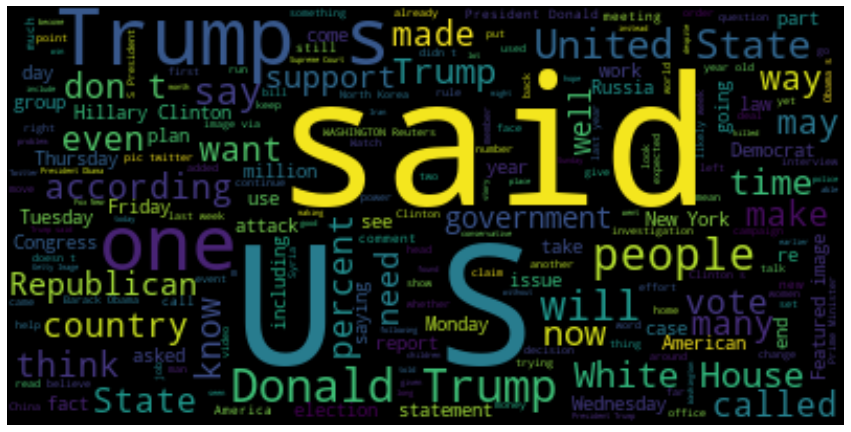

In [32]:
text_cloud3 = " ".join(i for i in total_news['text'])
stopwords1 = set(STOPWORDS)
total_news_text_wordcloud = WordCloud(stopwords = stopwords1, background_color = "black").generate(text_cloud3)
plt.figure(figsize = (15, 10))
plt.imshow(total_news_text_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

## Making All Letters Lowercase

In [33]:
total_news['title'] = total_news['title'].str.lower()
total_news['title'].head()

0     donald trump sends out embarrassing new year’...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama’s name...
4     pope francis just called out donald trump dur...
Name: title, dtype: object

In [34]:
total_news['text'] = total_news['text'].str.lower()
total_news['text'].head()

0    donald trump just couldn t wish all americans ...
1    house intelligence committee chairman devin nu...
2    on friday, it was revealed that former milwauk...
3    on christmas day, donald trump announced that ...
4    pope francis used his annual christmas day mes...
Name: text, dtype: object

## Removing Contractions

In [35]:
total_news['title'][24]

' white house: it wasn’t sexist for trump to slut-shame sen. kirsten gillibrand (video)'

In [36]:
title_list = total_news['title']
title_list[24]

' white house: it wasn’t sexist for trump to slut-shame sen. kirsten gillibrand (video)'

In [37]:
fixed_title_list = []
for i in range(len(title_list)):
    ans = contractions.fix(title_list[i])
    fixed_title_list.append(ans)

In [38]:
fixed_title_list[24]

' white house: it was not sexist for trump to slut-shame sen. kirsten gillibrand (video)'

In [39]:
total_news['title'] = fixed_title_list
total_news['title'][24]

' white house: it was not sexist for trump to slut-shame sen. kirsten gillibrand (video)'

In [40]:
text_list = total_news['text']

In [41]:
fixed_text_list = []
for i in range(len(text_list)):
    ans = contractions.fix(text_list[i])
    fixed_text_list.append(ans)

In [42]:
total_news['text'] = fixed_text_list
total_news.head()

,title,text,subject,date,label
0,donald trump sends out embarrassing new year’...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",1
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,News,"December 31, 2017",1
2,sheriff david clarke becomes an internet joke...,"on friday, it was revealed that former milwauk...",News,"December 30, 2017",1
3,trump is so obsessed he even has obama’s name...,"on christmas day, donald trump announced that ...",News,"December 29, 2017",1
4,pope francis just called out donald trump dur...,pope francis used his annual christmas day mes...,News,"December 25, 2017",1


## Removing Punctuation

In [43]:
total_news['title'] = total_news['title'].str.replace(r'[^\w\s]+', ' ')
total_news['title'].head()

C:\Users\Alan Donahue\AppData\Local\Temp\ipykernel_3552\4127223757.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  total_news['title'] = total_news['title'].str.replace(r'[^\w\s]+', ' ')


0     donald trump sends out embarrassing new year ...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama s name...
4     pope francis just called out donald trump dur...
Name: title, dtype: object

In [44]:
total_news['text'] = total_news['text'].str.replace(r'[^\w\s]+', ' ')
total_news['text'].head()

C:\Users\Alan Donahue\AppData\Local\Temp\ipykernel_3552\547650360.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  total_news['text'] = total_news['text'].str.replace(r'[^\w\s]+', ' ')


0    donald trump just couldn t wish all americans ...
1    house intelligence committee chairman devin nu...
2    on friday  it was revealed that former milwauk...
3    on christmas day  donald trump announced that ...
4    pope francis used his annual christmas day mes...
Name: text, dtype: object

## Removing Numbers

In [45]:
total_news['title'] = total_news['title'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
total_news['title'].head()

0     donald trump sends out embarrassing new year ...
1     drunk bragging trump staffer started russian ...
2     sheriff david clarke becomes an internet joke...
3     trump is so obsessed he even has obama s name...
4     pope francis just called out donald trump dur...
Name: title, dtype: object

In [46]:
total_news['text'] = total_news['text'].apply(lambda x: ''.join([i for i in x if not i.isdigit()]))
total_news['text'].head()

0    donald trump just couldn t wish all americans ...
1    house intelligence committee chairman devin nu...
2    on friday  it was revealed that former milwauk...
3    on christmas day  donald trump announced that ...
4    pope francis used his annual christmas day mes...
Name: text, dtype: object

## Removing Extra Space

In [47]:
total_news['title'] = total_news['title'].apply(lambda x: " ".join(x.split()))
total_news['title'].head()

0    donald trump sends out embarrassing new year s...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes an internet joke ...
3    trump is so obsessed he even has obama s name ...
4    pope francis just called out donald trump duri...
Name: title, dtype: object

In [48]:
total_news['text'] = total_news['text'].apply(lambda x: " ".join(x.split()))
total_news['text'].head()

0    donald trump just couldn t wish all americans ...
1    house intelligence committee chairman devin nu...
2    on friday it was revealed that former milwauke...
3    on christmas day donald trump announced that h...
4    pope francis used his annual christmas day mes...
Name: text, dtype: object

## Removing Stop Words

In [49]:
stop = nltk.corpus.stopwords.words('English')

In [50]:
total_news['title_no_stop'] = total_news['title'].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))
total_news['title_no_stop'].head()

0    donald trump sends embarrassing new year eve m...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama name coded website i...
4    pope francis called donald trump christmas speech
Name: title_no_stop, dtype: object

In [51]:
total_news['text_no_stop'] = total_news['text'].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))
total_news['text_no_stop'].head()

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text_no_stop, dtype: object

## Stemming Words

In [52]:
total_news['tokenized_title'] = total_news['title_no_stop'].apply(word_tokenize)
total_news['tokenized_title'].head()

0    [donald, trump, sends, embarrassing, new, year...
1    [drunk, bragging, trump, staffer, started, rus...
2    [sheriff, david, clarke, becomes, internet, jo...
3    [trump, obsessed, even, obama, name, coded, we...
4    [pope, francis, called, donald, trump, christm...
Name: tokenized_title, dtype: object

In [53]:
total_news['tokenized_text'] = total_news['text_no_stop'].apply(word_tokenize)
total_news['tokenized_text'].head()

0    [donald, trump, wish, americans, happy, new, y...
1    [house, intelligence, committee, chairman, dev...
2    [friday, revealed, former, milwaukee, sheriff,...
3    [christmas, day, donald, trump, announced, wou...
4    [pope, francis, used, annual, christmas, day, ...
Name: tokenized_text, dtype: object

In [54]:
porter = PorterStemmer()

In [55]:
total_news['title_stemmed'] = total_news['tokenized_title'].apply(lambda x: [porter.stem(word) for word in x])
total_news['title_stemmed'].head()

0    [donald, trump, send, embarrass, new, year, ev...
1    [drunk, brag, trump, staffer, start, russian, ...
2    [sheriff, david, clark, becom, internet, joke,...
3    [trump, obsess, even, obama, name, code, websi...
4    [pope, franci, call, donald, trump, christma, ...
Name: title_stemmed, dtype: object

In [56]:
total_news['text_stemmed'] = total_news['tokenized_text'].apply(lambda x: [porter.stem(word) for word in x])
total_news['text_stemmed'].head()

0    [donald, trump, wish, american, happi, new, ye...
1    [hous, intellig, committe, chairman, devin, nu...
2    [friday, reveal, former, milwauke, sheriff, da...
3    [christma, day, donald, trump, announc, would,...
4    [pope, franci, use, annual, christma, day, mes...
Name: text_stemmed, dtype: object

## Reverting Back To Strings

In [57]:
total_news['title_processed'] = total_news['title_stemmed'].apply(lambda x: ' '.join([word for word in x]))
total_news['title_processed'].head(10)

0    donald trump send embarrass new year eve messa...
1    drunk brag trump staffer start russian collus ...
2    sheriff david clark becom internet joke threat...
3        trump obsess even obama name code websit imag
4        pope franci call donald trump christma speech
5    racist alabama cop brutal black boy handcuff g...
6    fresh golf cours trump lash fbi deputi directo...
7    trump said insan racist stuff insid oval offic...
8    former cia director slam trump un bulli openli...
9    watch brand new pro trump ad featur much kiss ...
Name: title_processed, dtype: object

In [58]:
total_news['text_processed'] = total_news['text_stemmed'].apply(lambda x: ' '.join([word for word in x]))
total_news['text_processed'].head()

0    donald trump wish american happi new year leav...
1    hous intellig committe chairman devin nune go ...
2    friday reveal former milwauke sheriff david cl...
3    christma day donald trump announc would back w...
4    pope franci use annual christma day messag reb...
Name: text_processed, dtype: object

In [59]:
total_news.head()

,title,text,subject,date,label,title_no_stop,text_no_stop,tokenized_title,tokenized_text,title_stemmed,text_stemmed,title_processed,text_processed
0,donald trump sends out embarrassing new year s...,donald trump just couldn t wish all americans ...,News,"December 31, 2017",1,donald trump sends embarrassing new year eve m...,donald trump wish americans happy new year lea...,"[donald, trump, sends, embarrassing, new, year...","[donald, trump, wish, americans, happy, new, y...","[donald, trump, send, embarrass, new, year, ev...","[donald, trump, wish, american, happi, new, ye...",donald trump send embarrass new year eve messa...,donald trump wish american happi new year leav...
1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,News,"December 31, 2017",1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,"[drunk, bragging, trump, staffer, started, rus...","[house, intelligence, committee, chairman, dev...","[drunk, brag, trump, staffer, start, russian, ...","[hous, intellig, committe, chairman, devin, nu...",drunk brag trump staffer start russian collus ...,hous intellig committe chairman devin nune go ...
2,sheriff david clarke becomes an internet joke ...,on friday it was revealed that former milwauke...,News,"December 30, 2017",1,sheriff david clarke becomes internet joke thr...,friday revealed former milwaukee sheriff david...,"[sheriff, david, clarke, becomes, internet, jo...","[friday, revealed, former, milwaukee, sheriff,...","[sheriff, david, clark, becom, internet, joke,...","[friday, reveal, former, milwauke, sheriff, da...",sheriff david clark becom internet joke threat...,friday reveal former milwauke sheriff david cl...
3,trump is so obsessed he even has obama s name ...,on christmas day donald trump announced that h...,News,"December 29, 2017",1,trump obsessed even obama name coded website i...,christmas day donald trump announced would bac...,"[trump, obsessed, even, obama, name, coded, we...","[christmas, day, donald, trump, announced, wou...","[trump, obsess, even, obama, name, code, websi...","[christma, day, donald, trump, announc, would,...",trump obsess even obama name code websit imag,christma day donald trump announc would back w...
4,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,News,"December 25, 2017",1,pope francis called donald trump christmas speech,pope francis used annual christmas day message...,"[pope, francis, called, donald, trump, christm...","[pope, francis, used, annual, christmas, day, ...","[pope, franci, call, donald, trump, christma, ...","[pope, franci, use, annual, christma, day, mes...",pope franci call donald trump christma speech,pope franci use annual christma day messag reb...


## Splitting the Data

In [60]:
# final_df = total_news[['title_processed', 'text_processed', 'label']]
final_df = total_news[['text_processed', 'label']]
final_df.head()

,text_processed,label
0,donald trump wish american happi new year leav...,1
1,hous intellig committe chairman devin nune go ...,1
2,friday reveal former milwauke sheriff david cl...,1
3,christma day donald trump announc would back w...,1
4,pope franci use annual christma day messag reb...,1


In [61]:
x = final_df.text_processed

In [62]:
x.head()

0    donald trump wish american happi new year leav...
1    hous intellig committe chairman devin nune go ...
2    friday reveal former milwauke sheriff david cl...
3    christma day donald trump announc would back w...
4    pope franci use annual christma day messag reb...
Name: text_processed, dtype: object

In [63]:
y = final_df['label']
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

## Term Frequency - Inverse Document Frequency

In [65]:
tfidf = TfidfVectorizer()

In [66]:
tf_train = tfidf.fit_transform(x_train)

In [67]:
tf_test = tfidf.transform(x_test)

# Models

## Logistic Regression

In [68]:
logistic_regression = LogisticRegression(random_state = 0)

In [69]:
log_model = logistic_regression.fit(tf_train, y_train)

### Accuracy of Logistic Regression

In [70]:
log_pred = log_model.predict(tf_test)

In [71]:
log_accuracy = (accuracy_score(y_test, log_pred)) * 100
log_accuracy

98.3630289532294

### Logistic Regression Confusion Matrix

In [72]:
log_matrix = confusion_matrix(y_test, log_pred)
log_matrix

array([[4197,   60],
       [  87, 4636]], dtype=int64)

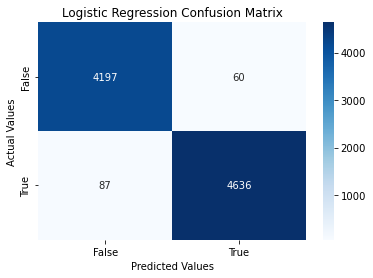

In [73]:
ax = sns.heatmap(log_matrix, annot = True, cmap = "Blues", fmt = "d")
ax.set_title("Logistic Regression Confusion Matrix")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

## Random Forest Model

In [74]:
randomforest = RandomForestClassifier(random_state = 0, n_jobs = -1)

In [75]:
forest_model = randomforest.fit(tf_train, y_train)

### Random Forest Model Accuracy

In [76]:
forest_pred = forest_model.predict(tf_test)

In [77]:
forest_accuracy = (accuracy_score(y_test, forest_pred)) * 100
forest_accuracy

98.99777282850779

### Random Forest Confusion Matrix

In [78]:
forest_matrix = confusion_matrix(y_test, forest_pred)
forest_matrix

array([[4225,   32],
       [  58, 4665]], dtype=int64)

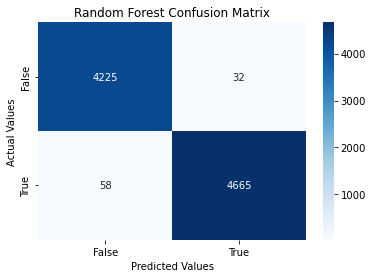

In [79]:
ax = sns.heatmap(forest_matrix, annot = True, cmap = "Blues", fmt = "d")
ax.set_title("Random Forest Confusion Matrix")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()

## Naive Bayes Model

In [80]:
naive_classifier = MultinomialNB()

In [81]:
naive_model = naive_classifier.fit(tf_train, y_train)

### Naive Bayes Accuracy

In [82]:
naive_pred = naive_model.predict(tf_test)

In [83]:
naive_accuracy = (accuracy_score(y_test, naive_pred)) * 100
naive_accuracy

93.38530066815144

### Naive Bayes Confusion Matrix

In [84]:
naive_matrix = confusion_matrix(y_test, naive_pred)
naive_matrix

array([[3926,  331],
       [ 263, 4460]], dtype=int64)

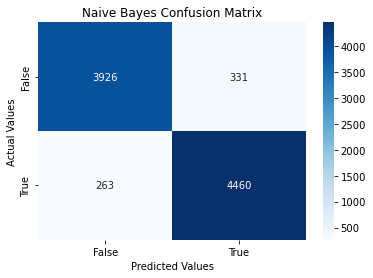

In [85]:
ax = sns.heatmap(naive_matrix, annot = True, cmap = "Blues", fmt = "d")
ax.set_title("Naive Bayes Confusion Matrix")
ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")
ax.xaxis.set_ticklabels(['False', 'True'])
ax.yaxis.set_ticklabels(['False', 'True'])
plt.show()